In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

df = pd.read_excel("Online_Retail.xlsx")
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
import seaborn as sns
sns.set_palette("husl")
sns.set(rc={'image.cmap': 'coolwarm'})
%matplotlib inline

In [15]:
df.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

In [5]:
import datetime as dt
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate']).dt.date

In [11]:
df = df[pd.notnull(df['CustomerID'])]

In [16]:
df = df[(df['Quantity']>0)]

In [20]:
df['Sales'] = df['Quantity'] * df['UnitPrice']
cols_of_interest = ['CustomerID', 'InvoiceDate', 'Sales']
df = df[cols_of_interest]

In [63]:
print(df.head())
print('Number of Entries: %s' % len(df))

   CustomerID InvoiceDate  Sales
0     17850.0  2010-12-01  15.30
1     17850.0  2010-12-01  20.34
2     17850.0  2010-12-01  22.00
3     17850.0  2010-12-01  20.34
4     17850.0  2010-12-01  20.34
Number of Entries: 397924


* frequency represents the number of repeat purchases the customer has made. This means that it’s one less than the total number of purchases.
* T represents the age of the customer in whatever time units chosen (daily, in our dataset). This is equal to the duration between a customer’s first purchase and the end of the period under study.
* recency represents the age of the customer when they made their most recent purchases. This is equal to the duration between a customer’s first purchase and their latest purchase. (Thus if they have made only 1 purchase, the recency is 0.)

In [26]:
from lifetimes.plotting import *
from lifetimes.utils import *
from lifetimes.estimation import *

data = summary_data_from_transaction_data(df, 'CustomerID', 'InvoiceDate', monetary_value_col='Sales', observation_period_end='2011-12-9')
data.head()

,frequency,recency,T,monetary_value
CustomerID,,,,
12346.0,0.0,0.0,325.0,0.000000
12347.0,6.0,365.0,367.0,599.701667
12348.0,3.0,283.0,358.0,301.480000
12349.0,0.0,0.0,18.0,0.000000
12350.0,0.0,0.0,310.0,0.000000


### Basic Frequency/Recency analysis using the BG/NBD model
We’ll use the BG/NBD model first, because this is the simplest to start with.

In [64]:
from lifetimes import BetaGeoFitter

# similar API to scikit-learn and lifelines.
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(data['frequency'], data['recency'], data['T'])
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 4339 subjects, a: 0.00, alpha: 69.03, b: 1.06, r: 0.83>


After fitting, we have lots of nice methods and properties attached to the fitter object.

For small samples sizes, the parameters can get implausibly large, so by adding an l2 penalty the likelihood, we can control how large these parameters can be. This is implemented as setting as positive penalizer_coef in the initialization of the model. In typical applications, penalizers on the order of 0.001 to 0.1 are effective.

### Visualizing our Frequency/Recency Matrix
Consider: a customer bought from us every day for three weeks straight, and we haven’t heard from them in months. What are the chances they are still “alive”? Pretty small. On the other hand, a customer who historically buys from us once a quarter, and bought last quarter, is likely still alive. We can visualize this relationship using the Frequency/Recency matrix, which computes the expected number of transactions a artificial customer is to make in the next time period, given his or her recency (age at last purchase) and frequency (the number of repeat transactions he or she has made).

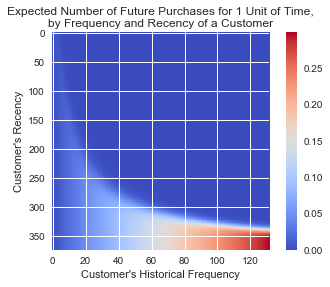

In [116]:
from lifetimes.plotting import plot_frequency_recency_matrix

plot_frequency_recency_matrix(bgf)

We can see that if a customer has bought 120 times from us, and their latest purchase was when they were 350 days old (given the individual is 350 days old), then they are our best customer (bottom-right). Customers who have purchased a lot and purchased recently will likely be the best customers in the future.

Customers who have purchased a lot but not recently (top-right corner), have probably dropped out.

There’s also that beautiful “tail” around (20,250). That represents the customer who buys infrequently, and we’ve not seen him or her very recently, so they might buy again - we’re not sure if they dropped out or just between purchases.

We can predict which customers are still alive:

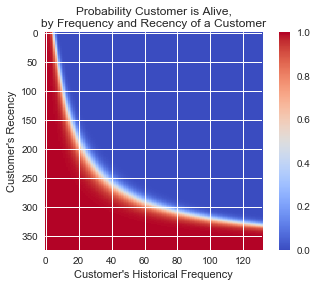

In [66]:
from lifetimes.plotting import plot_probability_alive_matrix

plot_probability_alive_matrix(bgf)

Customers who have purchased recently are almost surely "alive". 

Customers who have purchased a lot but not recently, are likely to have dropped out. And the more they bought in the past, the more likely they have dropped out. They are represented in the upper-right.

The matrix lets us estimate a behavioral propensity that we can never observe if someone is alive or not. 

### Ranking customers from best to worst

Let’s return to our customers and rank them from “highest expected purchases in the next period” to lowest. Models expose a method that will predict a customer’s expected purchases in the next period using their history.

In [72]:
t = 1
data['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, data['frequency'], data['recency'], data['T'])
data.sort_values(by='predicted_purchases').tail(5)

,frequency,recency,T,monetary_value,predicted_purchases
CustomerID,,,,,
14606.0,88.0,372.0,373.0,135.890114,0.200951
15311.0,89.0,373.0,373.0,677.729438,0.203214
17841.0,111.0,372.0,373.0,364.452162,0.252984
12748.0,113.0,373.0,373.0,298.360885,0.257509
14911.0,131.0,372.0,373.0,1093.661679,0.298229


We can see that the customer who has made 131 purchases, and bought very recently from us, has a probability of 29.8% to buy again in the next period (tomorrow).

### Assessing model fit
we can predict and we can visualize our customers’ behaviour, but is our model correct? There are a few ways to assess the model’s correctness. The first is to compare our data versus artificial data simulated with your fitted model’s parameters.

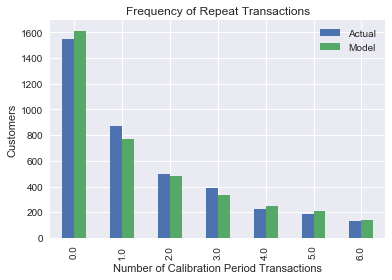

In [73]:
from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf)

This plot tells us for all customers in our data, how many purchases they make in our observation period, and what does the model predict? Looks nice?

More importantly, it tells us that our model doesn’t suck. So, we can continue on with our analysis.

### More model fitting
We can partition the dataset into a calibration period dataset and a holdout dataset. This is important as we want to test how our model performs on data not yet seen (think cross-validation in standard machine learning literature). Lifetimes has a function to partition our dataset like this:

In [104]:
from lifetimes.utils import calibration_and_holdout_data

summary_cal_holdout = calibration_and_holdout_data(df, 'CustomerID', 'InvoiceDate',
                                        calibration_period_end='2011-06-08',
                                        observation_period_end='2011-12-9' )   
print(summary_cal_holdout.head())

            frequency_cal  recency_cal  T_cal  frequency_holdout  \
CustomerID                                                         
12346.0               0.0          0.0  141.0                0.0   
12347.0               2.0        121.0  183.0                4.0   
12348.0               2.0        110.0  174.0                1.0   
12350.0               0.0          0.0  126.0                0.0   
12352.0               3.0         34.0  112.0                3.0   

            duration_holdout  
CustomerID                    
12346.0                  184  
12347.0                  184  
12348.0                  184  
12350.0                  184  
12352.0                  184  


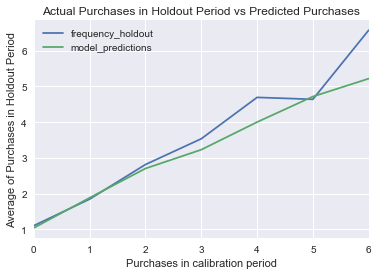

In [105]:
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout)

### Customer Predictions
Based on customer history, we can predict what an individuals future purchases might look like:

In [106]:
t = 10 #predict purchases in 10 periods
individual = data.iloc[20]
# The below function is an alias to `bfg.conditional_expected_number_of_purchases_up_to_time`
bgf.predict(t, individual['frequency'], individual['recency'], individual['T'])

0.088760211599876931

In [107]:
data.iloc[20]

frequency                3.000000
recency                309.000000
T                      360.000000
monetary_value         651.623333
predicted_purchases      0.008919
Name: 12370.0, dtype: float64

Customer ID 12370's predicted purchase is 0.008919 in 10 periods.

### Customer Probability Histories
Given a customer transaction history, we can calculate their historical probability of being alive, according to our trained model. For example:

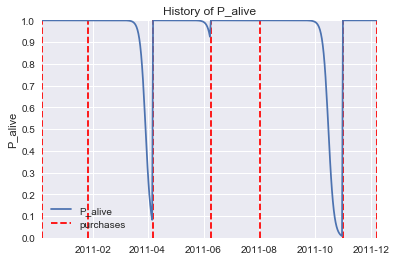

In [108]:
from lifetimes.plotting import plot_history_alive

id = 12347
days_since_birth = 365
sp_trans = df.loc[df['CustomerID'] == id]
plot_history_alive(bgf, days_since_birth, sp_trans, 'InvoiceDate')

### Estimating customer lifetime value using the Gamma-Gamma model
For this whole time we didn’t take into account the economic value of each transaction and we focused mainly on transactions’ occurrences. To estimate this we can use the Gamma-Gamma submodel. But first we need to create summary data from transactional data also containing economic values for each transaction (i.e. profits or revenues).

In [109]:
returning_customers_summary = data[data['frequency']>0]

print(returning_customers_summary.head())

            frequency  recency      T  monetary_value  predicted_purchases
CustomerID                                                                
12347.0           6.0    365.0  367.0      599.701667             0.015657
12348.0           3.0    283.0  358.0      301.480000             0.008961
12352.0           6.0    260.0  296.0      368.256667             0.018702
12356.0           2.0    303.0  325.0      269.905000             0.007174
12358.0           1.0    149.0  150.0      683.200000             0.008340


### The Gamma-Gamma model and the independence assumption
The model we are going to use to estimate the CLV for our userbase is called the Gamma-Gamma submodel, which relies upon an important assumption. The Gamma-Gamma submodel, in fact, assumes that there is no relationship between the monetary value and the purchase frequency. In practice we need to check whether the Pearson correlation between the two vectors is close to 0 in order to use this model.

In [110]:
returning_customers_summary[['monetary_value', 'frequency']].corr()

,monetary_value,frequency
monetary_value,1.000000,0.015882
frequency,0.015882,1.000000


At this point we can train our Gamma-Gamma submodel and predict the conditional, expected average lifetime value of our customers.

In [111]:
from lifetimes import GammaGammaFitter

ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(returning_customers_summary['frequency'],
        returning_customers_summary['monetary_value'])
print(ggf)

<lifetimes.GammaGammaFitter: fitted with 2790 subjects, p: 2.10, q: 3.45, v: 485.57>


We can now estimate the average transaction value:

In [112]:
print(ggf.conditional_expected_average_profit(
        data['frequency'],
        data['monetary_value']
    ).head(10))

CustomerID
12346.0    416.917661
12347.0    569.988799
12348.0    333.762677
12349.0    416.917661
12350.0    416.917661
12352.0    376.166865
12353.0    416.917661
12354.0    416.917661
12355.0    416.917661
12356.0    324.008947
dtype: float64


In [113]:
print("Expected conditional average profit: %s, Average profit: %s" % (
    ggf.conditional_expected_average_profit(
        data['frequency'],
        data['monetary_value']
    ).mean(),
    data[data['frequency']>0]['monetary_value'].mean()
))

Expected conditional average profit: 441.1283979957275, Average profit: 477.3586892535673


While for computing the total CLV using the [DCF method](https://en.wikipedia.org/wiki/Discounted_cash_flow) adjusting for cost of capital:

In [114]:
# refit the BG model to the summary_with_money_value dataset
bgf.fit(data['frequency'], data['recency'], data['T'])

print(ggf.customer_lifetime_value(
    bgf, #the model to use to predict the number of future transactions
    data['frequency'],
    data['recency'],
    data['T'],
    data['monetary_value'],
    time=12, # months
    discount_rate=0.01 # monthly discount rate ~ 12.7% annually
).head(10))

CustomerID
12346.0     295.248437
12347.0    3010.933981
12348.0    1008.692681
12349.0    1337.106359
12350.0     306.932918
12352.0    2372.739730
12353.0     426.098827
12354.0     386.464241
12355.0     411.043305
12356.0     784.161525
Name: clv, dtype: float64
